<a href="https://colab.research.google.com/github/KabirSubbiah/NLP/blob/main/Bag_of_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before you start


In this class, we will be using Google Colab notebooks for assignments instead of regular Python files. Colab provides more efficient Google GPU and is easier for setting up. Colab is also a very powerful platform and it functions very similarly to a Jupyter notebook. We'll provide a few tips on how to use Colab below; make sure you read them carefully!


☝ **Quick Colab Tips:**

- Make sure you **create a copy** of the Colab before you start coding!!! (File->Save a copy in Drive). If you don't do this, you will lose everything when you close the page and we DON'T want that to happen to you!
- Make sure you hit every play button that you need in previous cells, so that every function and variable you need is defined.
- If you don't want to click everything individually, you can click Runtime and you will find "Run Before", "Run After", or "Run All".
- When you reload the page, the runtime restarts and all variables in the environment are cleared, so you will need to re-run cells.
- If you make changes to a definition in an earlier cell, remember to run the cell to actually update the definition. Then remember to re-run the cells after, or else they will still be using the previous value.
- For more tips on getting started, please take a look at this [video](https://www.youtube.com/watch?v=inN8seMm7UI&ab_channel=TensorFlow).


**Collaboration policy form:**

Before you start coding, make sure to fill out the [collaboration policy form](https://docs.google.com/forms/d/e/1FAIpQLSeQ4mw2BUb8j0zY20UiWSenWRrkHsKOaUx-VXm1i3h3FTQQxg/viewform?usp=sf_link).


# Introduction


Welcome to your first assignment! In this assignment, you will be implementing your very first NLP model (Woohoo!) -- a Bag of Words (BOW) model for sentiment classification. In this assignment, you will be using a very useful NLP libary (spaCy), and a popular machine learning library (scikit-learn, or sklearn) to help you with preprocessing the data and building the BOW model. In later lectures and assignments, you will learn to implement many of these NLP and ML functions yourself, but in "the real world" it is often more practical to use existing libraries like those provided by spacy and sklearn than to implement these algorithms from scratch. So, in this assignment, we want you to learn how to use these libraries in a practical setting, and we'll later learn about how they work "under the hood".

The main learning objectives for this assignment are:

1. Use sklearn to implement a standard ML workflow (featurization, designing train-test splits, training a model, and evaluating the model).
2. Use spaCy for standard NLP preprocessing steps (tokenization, lemmatization, tagging).
3. Understand and implement common featurization approaches for text classifiers (ngrams, weighting schemas, tagging).


The basic workflow for an NLP model contains the following steps:

1. Load and Explore Data
2. Preprocess Data
3. Extract Features
4. Train the Model
5. Evaluate the Model
6. Analyze Model Behavior

You will implement this full workflow in Part 1. In Part 2, you will experiment with improvements to step 2 (preprocessing). In Part 3, you will experiment with improvements to step 3 (featurization).


### Installation and Imports


☝ **Quick Tip:** You can add "**!**" in front a Linux command and it can run on Colab!


In [ ]:
!pip install spacy
!pip install scikit-learn

import os
import spacy

from google.colab import drive

import numpy as np
import pandas as pd
import pickle
from typing import List, Tuple, TypeAlias

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Part 1: BOW Workflow


### Step 1: Load the raw data from disk and explore the data


In this assignment, we will use a Twitter dataset with social media text. Mount the path to your copied handout folder in the cell below, so that you can access it from this notebook.

In the dataset, the tweets are rated for three categories of sentiment: positive, negative and neutral. We will use the tweets in the `text` column and the sentiments in the `sentiment` column. Read the pandas documentation [here](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) if you are unfamiliar with dataframes.


In [ ]:
# Change this folder if you've placed the .csv elsewhere in your drive.
FOLDER = "/content/drive/My Drive/datasets"  # Extend this string to point to the directory with your copy of Tweets_5K.csv
FILEPATH = f"{FOLDER}/Tweets_5K.csv"

In [ ]:
def load_data() -> Tuple[List[str], List[int]]:


    df = pd.read_csv(
        FILEPATH,
        usecols=[1, 2],
    )
    """
    Loads Twitter data into two lists.

    Returns
    -------
    raw_tweets : List[str]
        A list of all Tweets in the dataset
    labels : List[int]
        A list of the sentiments corresponding to each raw tweet encoded as integers,
        -1 meaning negative, 0 meaning neutral, and 1 meaning positive
    """
    senti_dict = {'negative': -1, 'neutral': 0, 'positive': 1}

    text_list = df['text'].tolist()

    sentiment_list = [senti_dict[i] for i in df['sentiment']]

    return (text_list, sentiment_list)

Before you start to preprocess data, you should always take a look at the dataset and get a sense of the data you're handling.


In [ ]:
raw_tweets, labels = load_data()
for p, label in zip(raw_tweets[:10], labels[:10]):
    print(f"{label}:\t{p}\n")

0:	 I`d have responded, if I were going

-1:	 Sooo SAD I will miss you here in San Diego!!!

-1:	my boss is bullying me...

-1:	 what interview! leave me alone

-1:	 Sons of ****, why couldn`t they put them on the releases we already bought

0:	http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth

1:	2am feedings for the baby are fun when he is all smiles and coos

0:	Soooo high

0:	 Both of you

1:	 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)



We can use matplotlib to see the ratio between positive, negative and neutral sentiments.


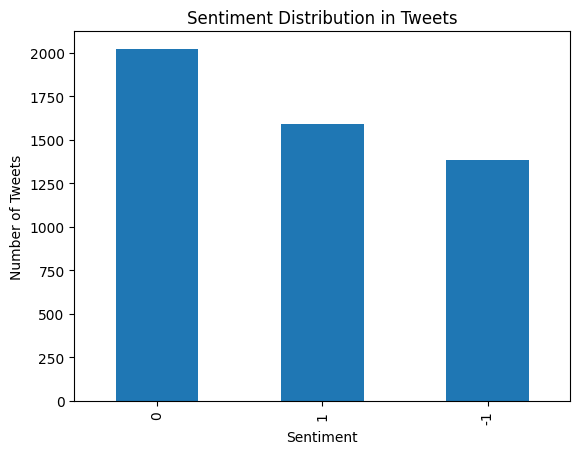

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
pd.value_counts(labels).plot.bar(title="Sentiment Distribution in Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

### Step 2: Preprocess the data


For now, all you need to do for preprocessing is split the tweets by whitespace.


In [ ]:
def preprocess(raw_X: List[str]) -> List[List[str]]:
    """
    Performs splitting on whitespace on all raw strings in a list.

    Parameters
    ----------
    raw_X : List[str]
        A list of raw strings (tweets)

    Returns
    -------
    List[List[str]]
        A list of preprocessed tweets (which are now lists of words)
    """
    processed_tweets = [[] for _ in range(len(raw_X))]

    for i in range(len(raw_X)):
      processed_tweets[i] = raw_X[i].split()

    return processed_tweets
    # TODO: Basic tokenization just based on whitespace, with no other preprocessing
    pass

### Step 3: Define the Model


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


class BOW_Classifier:
    """
    Attributes
    ----------
    clf : LogisticRegression
        A logistic regression classifier
    dv : DictVectorizer
        A dictionary vectorizer for turning dictionaries into matrices
    """

    def __init__(self):
        # TODO: Initialize class attributes
        # HINT: Use max_iter=150 when initializing your LogisticRegression classifier to get expected performance!
        # You are allowed to not use the dv attribute as well as add more to the init method if you wish
        self.clf = LogisticRegression(max_iter=150) #Specify solver, penalty and other hyperparameters
        self.dv = DictVectorizer()

    def featurize(
        self, preproc_X: np.ndarray[List[str]], is_test: bool = False
    ) -> csr_matrix:
        """
        Turns a list of preprocessed tweets into a binary bag of words
        matrix.

        Parameters
        ----------
        preproc_X : np.ndarray[List[str]]
            A list of preprocessed tweets
        is_test: bool, default=False
            Whether featurization should be done using features learned during training (is_test=True)
            or whether it should be done with features extracted from scratch using preproc_X (is_test=False)

        Returns
        -------
        csr_matrix
            A matrix with rows corresponding to tweets and columns corresponding to words
        """
        word_dicts = []
        for tweet in preproc_X:
          words = {}
          for word in tweet:
            words[word] = 1
          word_dicts.append(words)

        if (is_test):
          return self.dv.transform(word_dicts)

        else:
          return self.dv.fit_transform(word_dicts)


        # TODO: Implement a binary bag of words for unigrams
        pass

    def train(self, X_train: np.ndarray[List[str]], y_train: np.ndarray[int]):
        """
        Trains the BOW classifier on the given training data.

        Parameters
        ----------
        X_train : np.ndarray[List[str]]
            Preprocessed tweets for training
        y_train : np.ndarray[int]
            Sentiments corresponding to the tweets in X_train
        """
        feature_matrix = self.featurize(X_train, False)
        self.clf.fit(feature_matrix, y_train)


    def test(self, X_test: np.ndarray[List[str]]) -> np.ndarray[int]:
        """
        Classifies the given test data and returns predicted sentiments.

        Parameters
        ----------
        X_test : np.ndarray[List[str]]
            Preprocessed tweets for testing

        Returns
        -------
        y_pred : np.ndarray[int]
            Predicted sentiments for the tweets in X_test
        """
        feature_matrix = self.featurize(X_test, True)
        return self.clf.predict(feature_matrix)


### Step 4: Evaluate the model


To evaluate the model, we need to simulate the "real world" setting in which we have trained on our model on the data we have, but now we are using it to assign labels to data we have never seen before. We will do this using stratified k-fold cross validation.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called `k` that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. This procedure is called "stratified" when the data is divided so that examples from each class (in this case, classes are the three sentiments) are distributed evenly among all folds.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


def run_kfold_crossval(
    model: BOW_Classifier, X: List[List[str]], y: List[int], k: int = 5
) -> List[float]:
    """
    Executes stratified k-fold cross-validation.

    Parameters
    ----------
    model : BOW_Classifier
        A BOW model that has train and test methods
    X : List[List[str]]
        Preprocessed tweets for training and testing
    y : List[int]
        Sentiments corresponding to the tweets in X
    k : int, default=5
        The number of folds to use for cross-validation

    Returns
    -------
    List[float]
        A list of accuracy values from testing with each fold
    """

    skf = StratifiedKFold(n_splits=k)

    acc_scores = []

    X_array = np.array(X, dtype=list)
    y_array = np.array(y, dtype=int)

    for train_index, test_index in skf.split(X_array, y_array):
      x_train = [X_array[i] for i in train_index]
      y_train = [y_array[i] for i in train_index]
      x_test = [X_array[i] for i in test_index]
      y_test = [y_array[i] for i in test_index]

      model.train(x_train, y_train)

      y_pred = model.test(x_test)

      acc_scores.append(accuracy_score(y_test, y_pred))
    # TODO: Implement stratified k-fold cross-validation with a BOW_Classifier model
    # HINT: Consult the documentation for the imports at the top of this cell
    # HINT 2: If you have trouble casting a ragged nested list to a numpy array, try passing dtype=list
    return acc_scores

### Step 5: Analyze Model Performance


This function will plot how well our model is doing :)


In [ ]:
def plot_perfs(perfs: List[List[float]], names: List[str], k: int = 5):
    """
    Plots performances of models in a bar chart.

    Parameters
    ----------
    perfs : List[List[float]]
        A list of accuracy results for each model
    names : List[str]
        The names of each of the models (in the same order as perfs)
    k : int, default=5
        The value of k used for cross-validation when producing the performances
    """
    means = []
    stds = []
    for i, perf in enumerate(perfs):
        mean = np.mean(perf)
        means.append(mean)
        stds.append(np.std(perf))
        print("%s:\t%.03f" % (names[i], mean))
    plt.bar(np.arange(len(means)), means, yerr=stds)
    plt.xticks(np.arange(len(names)), names)
    plt.ylabel(f"Accuracy with {k} Folds")
    plt.ylim(0, 1)
    plt.show()

### Run full workflow!


MFC Baseline:	0.405
Basic BOW:	0.598


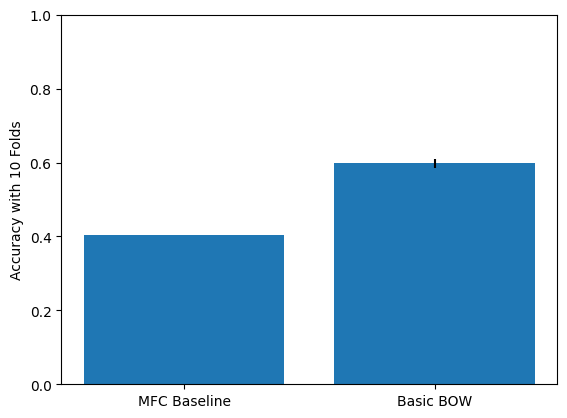

In [ ]:
from collections import Counter

K_FOLD = 10
raw_tweets, y = load_data()

X_preproc = preprocess(raw_tweets)
bow_model = BOW_Classifier()
basic_bow_accs = run_kfold_crossval(bow_model, X_preproc, y, k=K_FOLD)

# here, we are going generate the "most frequent class" baseline based on the
# training data
counts = Counter(y).values()
mfc_baseline = [max(counts) / sum(counts)] * K_FOLD

# plot the results!
plot_perfs([mfc_baseline, basic_bow_accs], ["MFC Baseline", "Basic BOW"], k=K_FOLD)

### ❗ Conceptual Questions (Answer in the Colab cell below). 👈👈👈 [Don't miss this section!]

You will need to write/copy some code, or add some print statements to the functions you’ve already written, to help you answer these questions.

Use one iteration of stratified k-fold cross-validation with k=5 (the default value) to retrieve feature matrices for a single train/test set.

1. What are the dimensions of your training feature matrix (let's call it M_train)?
2. What is the value of M_train[1460][1460]?
3. What feature does the 1460th column of M_train represent?
4. Find an example of a word that appears in the test set but never appears in the training set. What word did you find, and what is the tweet in which it occurred?
5. What happens to that new word when the tweet is featurized at test time? I.e., what is the feature representation of the tweet that contains the unknown word?


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


def run_kfold_crossval_conceptual(
    model: BOW_Classifier, X: List[List[str]], y: List[int], k: int = 5
):
    """
    Executes stratified k-fold cross-validation.

    Parameters
    ----------
    model : BOW_Classifier
        A BOW model that has train and test methods
    X : List[List[str]]
        Preprocessed tweets for training and testing
    y : List[int]
        Sentiments corresponding to the tweets in X
    k : int, default=5
        The number of folds to use for cross-validation

    Returns
    -------
    List[float]
        A list of accuracy values from testing with each fold
    """

    skf = StratifiedKFold(n_splits=k)

    feature_matrices = {'train': [], 'test': []}
    test_not_train = []

    X_array = np.array(X, dtype=list)
    y_array = np.array(y, dtype=int)

    for train_index, test_index in skf.split(X_array, y_array):
      x_train = [X_array[i] for i in train_index]
      y_train = [y_array[i] for i in train_index]
      x_test = [X_array[i] for i in test_index]
      y_test = [y_array[i] for i in test_index]

      feature_matrices['train'].append(model.featurize(x_train, False))
      feature_matrices['test'].append(model.featurize(x_test, True))

      for tweet in x_test:
          if test_not_train:
            test_not_train.append(model.dv.feature_names_)
            break
          for word in tweet:
              if word not in model.dv.feature_names_:
                test_not_train.append(word)
                break

    # TODO: Implement stratified k-fold cross-validation with a BOW_Classifier model
    # HINT: Consult the documentation for the imports at the top of this cell
    # HINT 2: If you have trouble casting a ragged nested list to a numpy array, try passing dtype=list
    return feature_matrices, test_not_train

In [ ]:
K_FOLD = 5
raw_tweets, y = load_data()

X_preproc = preprocess(raw_tweets)
bow_model = BOW_Classifier()
ftr_matrices, test_not_train = run_kfold_crossval_conceptual(bow_model, X_preproc, y, k=K_FOLD)


print(f"Feature matrix shape is {ftr_matrices['train'][0].shape}")
print(f"Feature matrix (1460,1460) is {ftr_matrices['train'][0][1460][0, 1460]}")
print(f"Feature matrix 1460th column represents {test_not_train[1][1459]}")
print(f"Word that is in test, but not train: {test_not_train[0]}")
print(f"Chosen word is in feature matrix: {test_not_train[0] in test_not_train[1]}") #Assumes first train-test had such a word

Feature matrix shape is (4000, 12877)
Feature matrix (1460,1460) is 0.0
Feature matrix 1460th column represents Don`t
Word that is in test, but not train: responded,
Chosen word is in feature matrix: False


### Conceptual Answers:

1. All feature matrices have 4500 as the first dimension and around 14000 as the second dimension.
2.Feature matrix (1460,1460) is 0.0, the word represented in this column is not in the tweet represented in the row
3.Feature matrix 1460th column represents 'Don`t'
4.Word that is in test, but not train: 'responded'
5.The word is 'silently ignored', meaning that it is excluded from the feature matrix


# Part 2: Improved Preprocessing


In this section, we are going to improve the preprocessing step, but otherwise keep the above workflow the same.


### Loading Data with Spacy

The cell block below will load the dataset into spacy_processed_docs, a list of Spacy Documents that will be passed to the preprocess_part2 function below.


In [ ]:
NUM_TWEETS = 5000  # INFO: Feel free to change this to load in fewer tweets for debugging but otherwise keep it at 5000

nlp = spacy.load("en_core_web_sm")

CACHE_PATH = f"{FOLDER}/parsed_tweets.pickle"

if os.path.exists(CACHE_PATH):
    print(f"Loading parsed tweets from cache at {CACHE_PATH}")
    parsed_tweets = pickle.load(open(CACHE_PATH, "rb"))
else:
    # parse all the tweets with spacy
    parsed_tweets = []
    for i, r in enumerate(raw_tweets):
        if i == NUM_TWEETS:
            break
        parsed_tweets.append(nlp(r))
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1} out of {len(raw_tweets)}", end="\r")
    print("Processing complete", " " * 10)
    if CACHE_PATH is not None:
        pickle.dump(parsed_tweets, open(CACHE_PATH, "wb"))

print(
    f"{len(parsed_tweets)} parsed tweets loaded."
)  # This should be 5000 when not debugging

Loading parsed tweets from cache at /content/drive/My Drive/datasets/parsed_tweets.pickle
5000 parsed tweets loaded.


Please program `preprocessing_part2` to do the following things (not necessarily in this order):

- lowercasing
- lemmatization
- remove stop words
- remove punctuation and extra white space
- use only top 1000 most frequent words, and replace the rest with "\<OOV\>"
- replace numbers with "\<NUM\>"

**Think about how each step affects the next one in the pipeline.** Specifically, one of these steps makes more sense to do last, so make sure your code reflects that.

Your final feature matrix should have 1001 columns (1000 most frequent words and one "\<OOV\>" token).

Use spacy to do these things. You shouldn't need to import any additional libraries (but hint: we've imported the Counter library in a previous cell). You can read the spacy documentation [here](http://spacy.pythonhumanities.com/01_02_linguistic_annotations.html#token-attributes) and [here](https://spacy.io/api/annotation#pos-tagging).


In [ ]:
spacy_doc: TypeAlias = spacy.tokens.doc.Doc


def preprocess_part2(parsed_tweets: List[spacy_doc]) -> List[List[str]]:
    """
    Preprocesses the spacy-parsed tweets.

    Parameters
    ----------
    parsed_tweets : List[spacy_doc]
        A list of tweets parsed by spacy

    Returns
    -------
        A list of preprocessed tweets formatted as lists of tokens (lists of strings)
    """
    preproc_X = [[] for _ in range(len(parsed_tweets))]

    cnt = Counter()

    for i, tweet in enumerate(parsed_tweets):
      for token in tweet:
        if token.is_stop or token.is_punct or token.is_space:
          pass
        else:
          if token.pos_ == "NUM":
            token = "<NUM>"
          else:
            token = token.lemma_.lower().strip()
          cnt[token] += 1
          preproc_X[i].append(token)

    top_1K = cnt.most_common(1000)

    for tweet in preproc_X:
      for word in tweet:
        if word not in top_1K:
          word = "<OOV>"

    return preproc_X

Now let's re-run the workflow and observe the difference in performance!


MFC Baseline:	0.405
Basic BOW:	0.598
BOW+preproc:	0.634


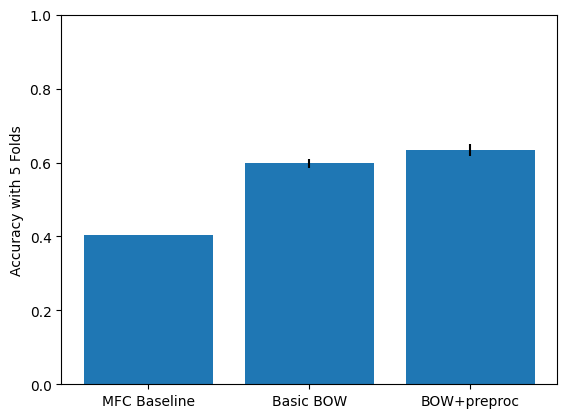

In [ ]:
X_preproc = preprocess_part2(parsed_tweets)
bow_model = BOW_Classifier()
better_preproc_accs = run_kfold_crossval(bow_model, X_preproc, y, k=K_FOLD)

plot_perfs(
    [mfc_baseline, basic_bow_accs, better_preproc_accs],
    ["MFC Baseline", "Basic BOW", "BOW+preproc"],
    k=K_FOLD,
)

# Part 3: Improved Featurization


In this section, we will expand the featurize function to include more advanced and sophisticated features. You will now add n-grams with n values from 1 to 5 as features to (partially) preserve the order of the sentence.


In [ ]:
from scipy.sparse import csr_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

class Better_BOW(BOW_Classifier):
    """
    A subclass of BOW_Classifier with a more complex featurization function.

    All attribute and method names match those of BOW_Classifier.
    """

    def __init__(self):
        # TODO: Initialize class attributes
        # HINT: Use max_iter=150 when initializing your LogisticRegression classifier to get expected performance!
        # You are allowed to not use the dv attribute as well as add more to the init method if you wish
        self.clf = LogisticRegression(max_iter=150) #Specify solver, penalty and other hyperparameters
        self.dv = DictVectorizer()
        self.cv = CountVectorizer(binary=True, ngram_range=(1, 5))



    def featurize(
        self, preproc_X: np.ndarray[List[str]], is_test: bool = False
    ) -> csr_matrix:

        if not is_test:
          bow_matrix = self.cv.fit_transform(" ".join(tweet) for tweet in preproc_X)
#     Transform the input data into a binary bag of words matrix
        bow_matrix = self.cv.transform(" ".join(tweet) for tweet in preproc_X)
        return bow_matrix
        """
        Turns a list of preprocessed tweets into a bag of words
        matrix using n-grams up to 5-grams.

        Parameters
        ----------
        preproc_X : List[List[str]]
            A list of preprocessed tweets
        is_test: bool, default=False
            Whether featurization should be done using features learned during training (is_test=True)
            or whether it should be done with features extracted from scratch using preproc_X (is_test=False)

        Returns
        -------
        csr_matrix
            A matrix with rows corresponding to tweets and columns corresponding to n-grams
        """
        def generate_ngram(tweet_words: List[str], n: int) -> List[str]:
          last_word = len(tweet_words) - n

          to_return = []
          for i in range(last_word):
            cur_token = ''
            for j in range(n):
              cur_token += tweet_words[i] + ' '
            to_return.append(cur_token.strip())
          return to_return

        # TODO: Implement a binary BOW for 1-, 2-, 3-, 4-, and 5-grams
        word_dicts = []
        for tweet in preproc_X:
          words = {}
          tweet_len = len(tweet)

          ngram2 = generate_ngram(tweet, 2)
          ngram3 = generate_ngram(tweet, 3)
          ngram4 = generate_ngram(tweet, 4)
          ngram5 = generate_ngram(tweet, 5)

          grams = tweet + ngram2 + ngram3 + ngram4 + ngram5
          for token in grams:
            words[token] = 1

          word_dicts.append(words)

        if (is_test):
          return self.dv.transform(word_dicts)

        else:
          return self.dv.fit_transform(word_dicts)


        # TODO: Implement a binary bag of words for unigrams


    def train(self, X_train: np.ndarray[List[str]], y_train: np.ndarray[int]):
        """
        Trains the BOW classifier on the given training data.

        Parameters
        ----------
        X_train : np.ndarray[List[str]]
            Preprocessed tweets for training
        y_train : np.ndarray[int]
            Sentiments corresponding to the tweets in X_train
        """
        feature_matrix = self.featurize(X_train, False)
        self.clf.fit(feature_matrix, y_train)


    def test(self, X_test: np.ndarray[List[str]]) -> np.ndarray[int]:
        """
        Classifies the given test data and returns predicted sentiments.

        Parameters
        ----------
        X_test : np.ndarray[List[str]]
            Preprocessed tweets for testing

        Returns
        -------
        y_pred : np.ndarray[int]
            Predicted sentiments for the tweets in X_test
        """
        feature_matrix = self.featurize(X_test, True)
        return self.clf.predict(feature_matrix)

MFC Baseline:	0.405
Basic BOW:	0.598
BOW+preproc:	0.634
Better Features:	0.638


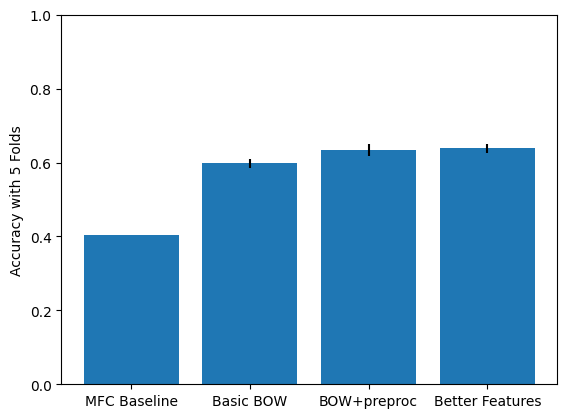

In [ ]:
X_preproc = preprocess_part2(parsed_tweets)
better_bow = Better_BOW()
better_feature_accs = run_kfold_crossval(better_bow, X_preproc, y, k=K_FOLD)

plot_perfs(
    [mfc_baseline, basic_bow_accs, better_preproc_accs, better_feature_accs],
    ["MFC Baseline", "Basic BOW", "BOW+preproc", "Better Features"],
    k=K_FOLD,
)

# Submission Instructions

Please submit this Colab as **two** files to Gradescope:

1.  A `.py` file: Click File > Download > Download .py
2.  A `.ipynb` file with outputs: Click Runtime > Run All, and then after all outputs are complete, click File > Download > Download .ipynb

Please ensure that the `.ipynb` contains actual function outputs (and not leftover print statements, for instance). We will run your `.ipynb` file; if our outputs don't match the outputs in your submitted file (within reason), you will receive a 0 on this assignment.


Last updated: 14 Sep 2023
